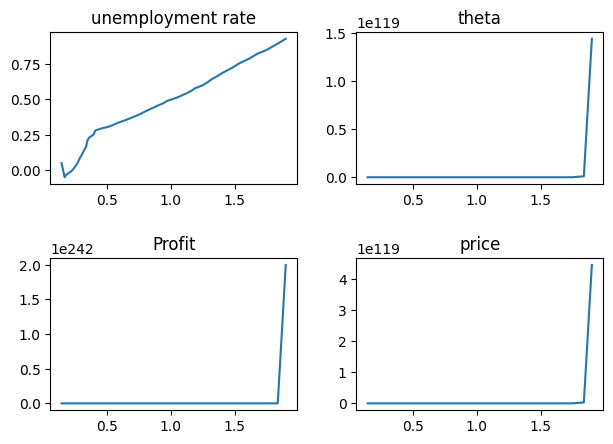

In [1]:
# 0811 V3 could show the results, but with several details to revise.
# Step 1: redefine class of firm by incorporating job finding rate and job separation rate
import random
import math
import itertools
import matplotlib.pyplot as plt

# Parameters
initial_population = 1000
simulation_years = 50

birth_rate = 0.011
death_rate = 0.23014
death_age = 80
retirement_age = 65

initial_participation_rate = 0.7
initial_aging_rate = 0.1
initial_unemployment_rate = 0.05

job_finding_rate = 0.2
job_separation_rate = 0.01

class Person:
    def __init__(self, age, employed):
        self.age = age
        self.employed = employed
    
    def update_age(self):
        self.age += 1
        
    def is_newborn(self):
        return self.age == 0
    
    def is_young(self):
        return self.age < 15
    
    def is_workforce(self):
        return 14 < self.age < retirement_age
    
    def is_senior(self):
        return self.age >= retirement_age 

    def is_unemployed(self):
        return not self.employed
    
    def is_employed(self):
        return self.employed

# Parameters for firm-related variables
#initial_price = 0.7
#initial_vacancy = 3
#initial_vacancy_cost = 0.6

# Initialize workforce data
initial_workforce = int(initial_population * initial_participation_rate)
initial_senior = int(initial_population * initial_aging_rate)
initial_unemp = int(initial_workforce * initial_unemployment_rate)

# Initialize population
newborn_coh = []
senior_coh = []
young_coh = []
workforce_coh = []
emp_coh = []
unemp_coh = []

random.seed(1)
for human in range(initial_population - initial_workforce):
    person = Person(age=random.randint(*random.choice([(0, 14), (65, 80)])), employed=False)
    senior_coh.append(person) if person.age >= 65 else young_coh.append(person)

for human in range(initial_unemp):
    person = Person(age=random.randint(15, 64), employed=False)
    unemp_coh.append(person)

for _ in range(initial_workforce - initial_unemp):
    person = Person(age=random.randint(15, 64), employed=True)
    emp_coh.append(person)

workforce_coh = list(itertools.chain(unemp_coh, emp_coh))

for _ in range(math.ceil(initial_population * birth_rate)):
    person = Person(age=0, employed=False)
    newborn_coh.append(person)

young_depen = list(itertools.chain(newborn_coh, young_coh))
pop = list(itertools.chain(young_depen, workforce_coh, senior_coh))

cohorts = [[len(young_depen)], [len(unemp_coh)], [len(emp_coh)], [len(senior_coh)]]
    
class Firm:
    def __init__(self, price, vacancy, vacancy_cost):
        self.price = price
        self.job_vacancy = vacancy
        self.vacancy_cost = vacancy_cost

    def hire_or_fire(self, labor_market, num_unemployed, num_employed):
        hire_or_fire_decision = self.price > self.vacancy_cost

        if hire_or_fire_decision:  # Hiring decision
            # count of employed in the labor market
            num_hired = int(num_unemployed * job_finding_rate)
            self.job_vacancy += num_hired
            return num_hired, 0, self.job_vacancy

        else:  # Firing decision
            num_fired = int(num_employed * job_separation_rate)
            self.job_vacancy -= num_fired
            return 0, num_fired, self.job_vacancy

    def post_price(self, price):
        self.price = price
        # Open new job vacancies based on price and vacancy cost difference
        num_new_vacancies = int((price - self.vacancy_cost) * 10)
        self.job_vacancy += num_new_vacancies
        return self.job_vacancy

shopping_propensity_retirees = 0.1
shopping_propensity_unemployed = 0.1
shopping_propensity_employed = 0.9

class GoodsMarket:
    def __init__(self, firms):
        self.firms = firms

    def calculate_demand(self, consumers):
        total_demand = 0
        for consumer in consumers:
            if consumer.is_senior():
                total_demand += shopping_propensity_retirees
            elif consumer.is_employed():
                total_demand += shopping_propensity_employed
            elif consumer.is_unemployed():
                total_demand += shopping_propensity_unemployed
        return round(total_demand)

    def update_prices(self, total_demand):
        average_price = sum(firm.price for firm in self.firms) / len(self.firms)
        for firm in self.firms:
            firm.post_price(firm.price * (firm.price / average_price) * (1 + total_demand / len(self.firms)))


class LaborMarket:
    def __init__(self, firms, people, initial_unemployment_rate):
        self.firms = firms
        self.people = people
        self.initial_unemployment_rate = initial_unemployment_rate

    def new_workstatus(self, num_unemployed, num_employed):
        goods_market = GoodsMarket(self.firms)
        new_emp, new_unemp = 0, 0
        
        for firm in self.firms:
            hired, fired, job = firm.hire_or_fire(self, num_unemployed, num_employed)
            new_emp += hired
            new_unemp = fired
        return new_emp, new_unemp
    
    def calculate_unemployed(self):
        return sum(1 for person in workforce_coh if person.is_unemployed())

    def calculate_employed(self):
        return sum(1 for person in workforce_coh if person.is_employed())

    def total_job_vacancies(self):
        return sum(firm.job_vacancy for firm in self.firms)  




# Initialize the goods market with firms
random.seed(2)
num_firms = 10
firms = [Firm(random.uniform(0.5, 1), random.randint(1, 5), \
              random.uniform(0.5, 1)) for _ in range(num_firms)]
goods_market = GoodsMarket(firms)
price_history = [sum(firm.price for firm in firms) / len(firms)]

# Initialize the LaborMarket with firms and initial_workforce
labor_market = LaborMarket(firms, initial_workforce, initial_unemployment_rate)  # Pass initial_workforce here

# Simulation loop

n = simulation_years
unemployment_rates = [initial_unemployment_rate]  # Store unemployment rates over time
old_aged_dependency_ratios = [initial_senior / initial_workforce]
initial_vacancy = labor_market.total_job_vacancies()

theta = [initial_vacancy / labor_market.calculate_unemployed()]

firm_profits = [0]

prices_in_goods_market = [sum(firm.price for firm in firms) / len(firms)]

random.seed(3)
for year in range(1, n):
    young_this_year = 0
    workforce_this_year = 0
    unemp_this_year = 0
    emp_this_year = 0
    senior_this_year = 0
    newborn_this_year = 0
    for person in pop:             
        if person.is_young():
            young_this_year += 1
            
        if person.is_workforce():
            if person.is_unemployed():
                unemp_this_year += 1
            
            if person.is_employed():
                emp_this_year += 1
                    
        if person.is_senior():
                senior_this_year += 1
            

        person.update_age()
        
    # Goods market dynamics
    total_demand = goods_market.calculate_demand(pop)
    goods_market.update_prices(total_demand)

    newborn_this_year = math.ceil((senior_this_year + workforce_this_year) * birth_rate)

    for _ in range(newborn_this_year):
        person = Person(age=0, employed=False)
        pop.append(person)

    # Calculate the number of workers who found jobs and those who became unemployed this year
    num_unemployed = labor_market.calculate_unemployed()
    num_employed = labor_market.calculate_employed()
    emp_new_hire_this_year, unemp_new_hire_this_year = labor_market.new_workstatus(num_unemployed, num_employed)

   # Calculate the updated numbers of employed and unemployed workers for this year
    emp_this_year += emp_new_hire_this_year - unemp_new_hire_this_year
    unemp_this_year += unemp_new_hire_this_year - emp_new_hire_this_year

    # Update the number of senior citizens considering the death rate
    death = math.ceil(senior_this_year * death_rate)
    senior_this_year -= death
    
    # Store the values in cohorts list
    my_list = [young_this_year, unemp_this_year, emp_this_year, senior_this_year]
    [cohorts[i].append(my_list[i]) for i in range(len(cohorts))]

    # Calculate the updated total population
    tot_pop = sum(cohorts[i][year] for i in range(len(cohorts)))
   
    # Calculate the updated unemployment rate for this year and append it to the list
    updated_unemployment_rate = unemp_this_year / (unemp_this_year + emp_this_year)
    unemployment_rates.append(updated_unemployment_rate)

    # Calculate the updated aged dependency rate for this year and append it to the list
    updated_old_aged_dependency_ratios = senior_this_year / (unemp_this_year + emp_this_year)
    old_aged_dependency_ratios.append(updated_old_aged_dependency_ratios)


    # Calculate firm-related variables
    num_job_vacancies = sum(firm.job_vacancy for firm in firms)
    #job_vacancies.append(num_job_vacancies)

    total_firm_profits = sum((firm.price - firm.vacancy_cost)* firm.job_vacancy for firm in firms)
    firm_profits.append(total_firm_profits)
    
    # Calculate labor market tightness
    updated_theta = num_job_vacancies / unemp_this_year
    theta.append(updated_theta)
    
    #total_costs_to_open_vacancy = sum(firm.vacancy_cost * firm.job_vacancy for firm in firms)
    #costs_to_open_vacancy.append(total_costs_to_open_vacancy)

    total_prices_in_goods_market = sum(firm.price for firm in firms) / len(firms)
    prices_in_goods_market.append(total_prices_in_goods_market)
    
# Plot results
fig, axs = plt.subplots(2,2)
axs[0,0].plot(old_aged_dependency_ratios, unemployment_rates, label="Unemployment Rate")
axs[0, 0].set_title('unemployment rate')
axs[0,1].plot(old_aged_dependency_ratios, theta, label="Labor Market Tightness")
axs[0, 1].set_title('theta')
axs[1,0].plot(old_aged_dependency_ratios, firm_profits, label="Firm Profits")
axs[1, 0].set_title('Profit')
axs[1,1].plot(old_aged_dependency_ratios, prices_in_goods_market, label="Prices in Goods Market")
axs[1, 1].set_title('price')
fig.tight_layout(pad=2.0)
plt.show()